In [45]:
%matplotlib inline
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt

In [3]:
def ConvertToHex(value,bitwidth):
    """
    Converts the value field to 2's compliment hex format
    :param value:  value to convert
    :param bitwidth:   bitwidth of number
    :return:  converted value
    """
    value = int(value)
    if (value > (2**(bitwidth-1) - 1)):
        print('bit conversion failed, too positive')
        return "NULL"
    if (value < -(2**(bitwidth))):
        print('bit conversiion failed, too negative')
        return "NULL"
    # handle negative calculation
    if (value < 0):
        # wrap around to larger positive value, since
        # hex(-100) = -0x64, a not useful response
        value = value + 2**bitwidth;
    value_string = hex(value)
    # now if the value was positive, we want it
    # to take up the correct number of bits
    # chop of the 0x portion
    value_string = value_string[2: ]
    zeros_to_pad = bitwidth // 4 - len(value_string)
    string_out = zeros_to_pad*'0' + value_string
    return string_out


In [6]:
t = np.linspace(0,2*np.pi,1025)

In [7]:
cos_lut = np.cos(t)
cos_lut = cos_lut[0:1024]

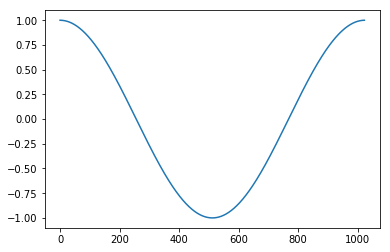

In [8]:
plt.plot(cos_lut)

In [9]:
cos_lut_scale = (2**15-1)*cos_lut

In [10]:
cos_lut_scale_floor = np.floor(cos_lut_scale)
cos_lut_scale_round = np.round(cos_lut_scale)

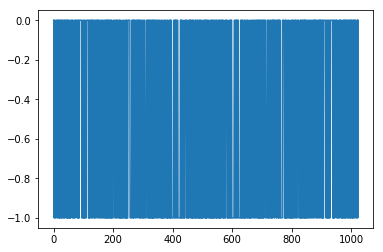

In [11]:
plt.plot(cos_lut_scale_floor  - cos_lut_scale_round)

In [12]:
cos_lut_round_hex = []
cos_lut_floor_hex = []
for x, item in enumerate(cos_lut_scale_floor):
    cos_lut_floor_hex.append(ConvertToHex(item, 16))
    cos_lut_round_hex.append(ConvertToHex(cos_lut_scale_round[x], 16))

In [13]:
cos_lut_floor_hex[1]

'7ffe'

In [14]:
f1 = open('cos_floor.dat', 'w')
f2 = open('cos_round.dat', 'w')
for floored, rounded in zip(cos_lut_floor_hex, cos_lut_round_hex):
    f1.write(f'{floored}\n')
    f2.write(f'{rounded}\n')
f1.close()
f2.close()


In [15]:
cos_lut_round_hex[0]

'7fff'

In [16]:
cos_lut_round_hex[768]

'0000'

In [17]:
cos_lut_floor_hex[768]

'ffff'

Ok, so now let's simulate it like we would an FPGA, with an NCO of certain width, NCO step, and the MSBs generating an address into the LUT

In [22]:
nco_bit_size = 32
nco_accum = np.zeros(65536)
t = np.arange(65536)
nco_step = 250e6/1.28125e9*2**nco_bit_size
phase = np.zeros(65536)
cos_out = np.zeros(65536)
sin_out = np.zeros(65536)
addr_size = 10

In [39]:
for x in range(65536):
    nco_accum[x] = nco_accum[x-1] + nco_step;
    if (nco_accum[x] > 2**nco_bit_size - 1):
        nco_accum[x] = nco_accum[x] - 2**nco_bit_size
    phase[x] = int(nco_accum[x] / 2**(nco_bit_size - addr_size))
    phase[x] = phase[x].astype(int)
    if (phase[x] > 1023):
        phase[x] = phase[x] - 1024
    
    cos_out[x] = cos_lut_scale_round[phase[x].astype(int)]
    sin_out[x] = cos_lut_scale_round[np.mod(phase[x].astype(int)+768,1024)]


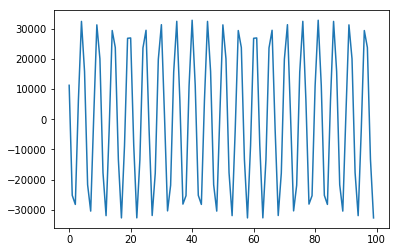

In [44]:
plt.plot(cos_out[0:100])

Text(0.5,1,'32-bit NCO with 10 bit addr')

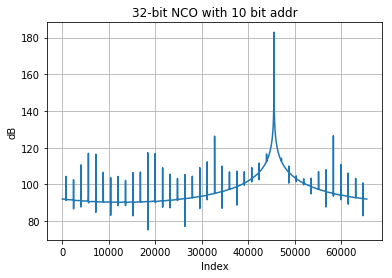

In [48]:
freq_axis = np.linspace(-640.625,640.625,65536)
plt.plot(freq_axis,20*np.log10(np.abs(fftpack.fftshift(fftpack.fft(cos_out + 1j*sin_out)))))
plt.grid(True)
plt.xlabel('Index')
plt.ylabel('dB')
plt.title("32-bit NCO with 10 bit addr")

Now let's repeat with a 32-bit NCO but we use the 12 MSBs

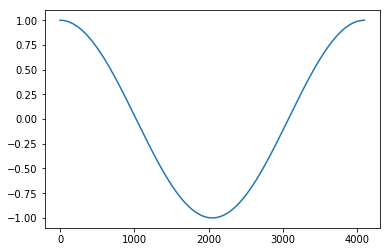

In [51]:
t = np.linspace(0,2*np.pi,4097)
cos_lut = np.cos(t)
cos_lut = cos_lut[0:4096]
plt.plot(cos_lut)
cos_lut_scale = (2**15-1)*cos_lut
cos_lut_scale_round = np.round(cos_lut_scale)

In [52]:
nco_bit_size = 32
nco_accum = np.zeros(65536)
t = np.arange(65536)
nco_step = 250e6/1.28125e9*2**nco_bit_size
phase = np.zeros(65536)
cos_out = np.zeros(65536)
sin_out = np.zeros(65536)
addr_size = 12

In [55]:
for x in range(65536):
    nco_accum[x] = nco_accum[x-1] + nco_step;
    if (nco_accum[x] > 2**nco_bit_size - 1):
        nco_accum[x] = nco_accum[x] - 2**nco_bit_size
    phase[x] = int(nco_accum[x] / 2**(nco_bit_size - addr_size))
    phase[x] = phase[x].astype(int)
    if (phase[x] > 4095):
        phase[x] = phase[x] - 4096
    
    cos_out[x] = cos_lut_scale_round[phase[x].astype(int)]
    sin_out[x] = cos_lut_scale_round[np.mod(phase[x].astype(int)+3072,4096)]


Text(0.5,1,'32-bit NCO with 12 bit addr')

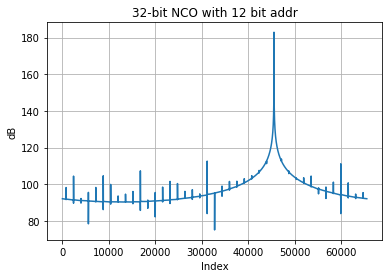

In [57]:
freq_axis = np.linspace(-640.625,640.625,65536)
plt.plot(freq_axis,20*np.log10(np.abs(fftpack.fftshift(fftpack.fft(cos_out + 1j*sin_out)))))
plt.grid(True)
plt.xlabel('Frequency')
plt.ylabel('dB')
plt.title("32-bit NCO with 12 bit addr")

For my benefit let's go ahead with 16-bit I/Q just to see how much better it gets

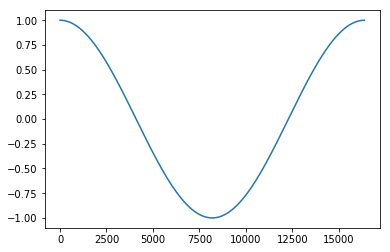

In [60]:
t = np.linspace(0,2*np.pi,16387)
cos_lut = np.cos(t)
cos_lut = cos_lut[0:16384]
plt.plot(cos_lut)
cos_lut_scale = (2**15-1)*cos_lut
cos_lut_scale_round = np.round(cos_lut_scale)

In [64]:
nco_bit_size = 32
nco_accum = np.zeros(65536)
t = np.arange(65536)
nco_step = 250e6/1.28125e9*2**nco_bit_size
phase = np.zeros(65536)
cos_out = np.zeros(65536)
sin_out = np.zeros(65536)
addr_size = 14


In [66]:
for x in range(65536):
    nco_accum[x] = nco_accum[x-1] + nco_step;
    if (nco_accum[x] > 2**nco_bit_size - 1):
        nco_accum[x] = nco_accum[x] - 2**nco_bit_size
    phase[x] = int(nco_accum[x] / 2**(nco_bit_size - addr_size))
    phase[x] = phase[x].astype(int)
    if (phase[x] > 16383):
        phase[x] = phase[x] - 16384
    
    cos_out[x] = cos_lut_scale_round[phase[x].astype(int)]
    sin_out[x] = cos_lut_scale_round[np.mod(phase[x].astype(int)+12288,16384)]

Text(0.5,1,'32-bit NCO with 14 bit addr')

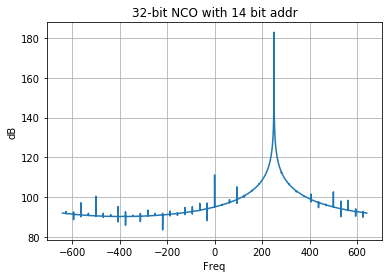

In [71]:
freq_axis = np.linspace(-640.625,640.625,65536)
plt.plot(freq_axis,20*np.log10(np.abs(fftpack.fftshift(fftpack.fft(cos_out + 1j*sin_out)))))
plt.grid(True)
plt.xlabel('Freq')
plt.ylabel('dB')
plt.title("32-bit NCO with 14 bit addr")